In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import os 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import geopandas as gpd
from scipy import ndimage
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import shapely
from geopandas import GeoDataFrame
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


### Research question: 
#### The question for this project is to find out tendency for fatalities due to road accidents in NYC for period from 2009 to 2016, localize some high-risk locations for 5 boroughs for 3 major groups – pedestrians, bikers, and motor vehicle occupants, and explore what is the change for last years for these locations?

In [2]:
#os.system("curl -O http://www.nyc.gov/html/dot/downloads/misc/fatality_yearly.csv")
#os.system("mv fatality_yearly.csv " + os.getenv("PUIDATA"))

In [3]:
fatalities_data = pd.read_csv(os.getenv("PUIDATA") + '/' + 'fatality_yearly.csv')
fatalities_data.head()

,Fatalities,PedFatalities,BikeFatalities,MVOFatalities,YR,nodeX,nodeY,STREET1,STREET2
0,1,0,0,1,2010,1.004135e+06,173254.3727,EAST 51 STREET,AVENUE D
1,1,1,0,0,2014,9.863667e+05,184764.6742,2 AVENUE,7 STREET
2,1,1,0,0,2009,1.028472e+06,176277.7489,90 STREET,164 AVENUE
3,1,0,0,1,2016,9.218182e+05,125321.6385,RICHARD AVENUE,BARTOW AVENUE
4,1,0,0,1,2015,1.051170e+06,192372.0175,116 AVENUE,194 STREET


In [4]:
#Number of Fatalities from annual dataset for 2009 - 2016 period
TotaFatalities = sum(fatalities_data.Fatalities)
TotalPedFatalities = sum(fatalities_data.PedFatalities)
TotalBikeFatalities = sum(fatalities_data.BikeFatalities)
TotalMVOFatalities = sum(fatalities_data.MVOFatalities)

print 'Total Number of All Fatalities 2009 - 2016: ', TotaFatalities 
print 'Total Number of Ped Fatalities 2009 - 2016: ', TotalPedFatalities
print 'Total Number of Cyc Fatalities 2009 - 2016: ', TotalBikeFatalities
print 'Total Number of MVO Fatalities 2009 - 2016: ', TotalMVOFatalities

Total Number of All Fatalities 2009 - 2016:  60726
Total Number of Ped Fatalities 2009 - 2016:  35862
Total Number of Cyc Fatalities 2009 - 2016:  4080
Total Number of MVO Fatalities 2009 - 2016:  20784


In [5]:
#Preparing data set for vizualization 
fatalities_data_ = fatalities_data[['YR','Fatalities','PedFatalities','BikeFatalities','MVOFatalities']]

In [6]:
#Preparing data set for vizualization 
TotalFatalitiesByYear = (fatalities_data_.groupby(['YR'],as_index=False).sum())
TotalFatalitiesByYear.head(8)

,YR,Fatalities,PedFatalities,BikeFatalities,MVOFatalities
0,2009,8797,5654,357,2786
1,2010,8916,5444,515,2957
2,2011,7818,4261,545,3012
3,2012,7571,4153,511,2907
4,2013,9071,5606,336,3129
5,2014,6042,3716,529,1797
6,2015,7150,3650,588,2912
7,2016,5361,3378,699,1284


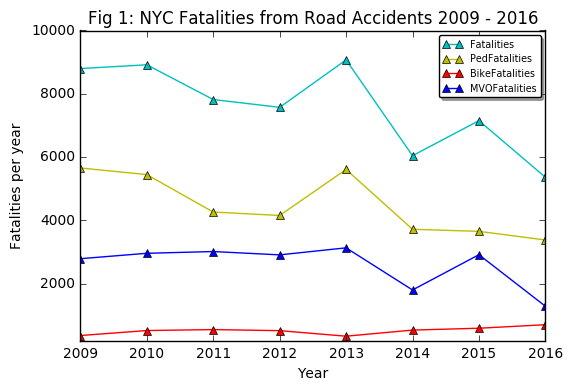

In [7]:
pl.rcParams['axes.formatter.useoffset'] = False
x = TotalFatalitiesByYear['YR']
y = TotalFatalitiesByYear['Fatalities']
pl.xlabel('Year')
pl.ylabel('Fatalities per year')
pl.xlim(1,12)
pl.ylim(200, 10000)
pl.title('NYC Total Fatalities from Road Accidents 2009 - 2016') #plot shows the trend for last years 
pl.plot(x, y, 'c-^')
pl.legend(loc = 'upper left')
pl.axis([2009, 2016, 200, 10000])

pl.rcParams['axes.formatter.useoffset'] = False
x = TotalFatalitiesByYear['YR']
y = TotalFatalitiesByYear['PedFatalities']
pl.xlabel('Year')
pl.ylabel('Fatalities per year')
pl.xlim(1,12)
pl.ylim(200, 10000)
pl.title('NYC Total Fatalities from Road Accidents 2009 - 2016')  
pl.plot(x, y, 'y-^')
pl.legend(loc = 'upper left')
pl.axis([2009, 2016, 200, 10000])

pl.rcParams['axes.formatter.useoffset'] = False
x = TotalFatalitiesByYear['YR']
y = TotalFatalitiesByYear['BikeFatalities']
pl.xlabel('Year')
pl.ylabel('Fatalities per year')
pl.xlim(1,12)
pl.ylim(200, 10000)
pl.title('NYC Total Fatalities from Road Accidents 2009 - 2016') 
pl.plot(x, y, 'r-^')
pl.legend(loc = 'upper left')
pl.axis([2009, 2016, 200, 10000])

pl.rcParams['axes.formatter.useoffset'] = False
x = TotalFatalitiesByYear['YR']
y = TotalFatalitiesByYear['MVOFatalities']
pl.xlabel('Year')
pl.ylabel('Fatalities per year')
pl.xlim(1,12)
pl.ylim(200, 10000)
pl.title('Fig 1: NYC Fatalities from Road Accidents 2009 - 2016')  
pl.plot(x, y, 'b-^')
pl.legend(shadow=True, fancybox=True, loc = 'upper right', fontsize = 'x-small')
pl.axis([2009, 2016, 200, 10000])
savefig('NYC Fatalities from Road Accidents 2009 - 2016.png')

#### Figure 1 represents total number of fatalities from road accidents over 2009 - 2016 for 3 major groups in New York City: 1) Pedestrians; 2) Bicyclists; 3)Motor Vehicle Occupants (MVO).  

### Display trends for 2009 - 2016 for 3 major groups

In [8]:
#loading monthly fatalities data set  
os.system("curl -O http://www.nyc.gov/html/dot/downloads/misc/fatality_monthly.csv")
os.system("mv fatality_monthly.csv " + os.getenv("PUIDATA"))

0

In [9]:
fatalities_monthly = pd.read_csv(os.getenv("PUIDATA") + '/' + 'fatality_monthly.csv')

In [10]:
fatalities_monthly.head()

,Fatalities,PedFatalit,BikeFatali,MVOFatalit,MN,YR,nodeX,nodeY,STREET1,STREET2
0,1,0,0,1,3,2010,1.004135e+06,173254.3727,EAST 51 STREET,AVENUE D
1,1,1,0,0,5,2014,9.863667e+05,184764.6742,2 AVENUE,7 STREET
2,1,1,0,0,11,2009,1.028472e+06,176277.7489,90 STREET,164 AVENUE
3,1,0,0,1,5,2016,9.218182e+05,125321.6385,RICHARD AVENUE,BARTOW AVENUE
4,1,0,0,1,6,2015,1.051170e+06,192372.0175,116 AVENUE,194 STREET


In [11]:
#Number of fatalities distributed by groups
MonthlyFatalities = sum(fatalities_monthly.Fatalities)
MonthlyPedFatalities = sum(fatalities_monthly.PedFatalit)
MonthlyBikeFatalities = sum(fatalities_monthly.BikeFatali)
MonthlyMVOFatalities = sum(fatalities_monthly.MVOFatalit)

print 'Total Number of All Monthly Fatalities 2009 - 2016: ', MonthlyFatalities 
print 'Total Number of Ped Monthly Fatalities 2009 - 2016: ', MonthlyPedFatalities
print 'Total Number of Cyc Monthly Fatalities 2009 - 2016: ', MonthlyBikeFatalities
print 'Total Number of MVO Monthly Fatalities 2009 - 2016: ', MonthlyMVOFatalities

Total Number of All Monthly Fatalities 2009 - 2016:  60074
Total Number of Ped Monthly Fatalities 2009 - 2016:  35472
Total Number of Cyc Monthly Fatalities 2009 - 2016:  3993
Total Number of MVO Monthly Fatalities 2009 - 2016:  20609


Total numbers in the data set for monthly fatalities is slightly different from yearly fatalities, but it doesn't affect the main picture. 

In [12]:
#preparing data set for vizualization of trends
fatalities_data_monthly =\
fatalities_monthly[['YR','MN','Fatalities','PedFatalit','BikeFatali','MVOFatalit']]

In [13]:
fatalities_data_monthly.head()

,YR,MN,Fatalities,PedFatalit,BikeFatali,MVOFatalit
0,2010,3,1,0,0,1
1,2014,5,1,1,0,0
2,2009,11,1,1,0,0
3,2016,5,1,0,0,1
4,2015,6,1,0,0,1


In [14]:
#merging YR and MN columns to Date column
fatalities_data_monthly['Date'] = fatalities_data_monthly.\
apply(lambda x: pd.datetime.strptime("{0} {1}".format(x['YR'],x['MN']), "%Y %m"),axis=1)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
fatalities_data_monthly.head()

,YR,MN,Fatalities,PedFatalit,BikeFatali,MVOFatalit,Date
0,2010,3,1,0,0,1,2010-03-01
1,2014,5,1,1,0,0,2014-05-01
2,2009,11,1,1,0,0,2009-11-01
3,2016,5,1,0,0,1,2016-05-01
4,2015,6,1,0,0,1,2015-06-01


In [16]:
#group data by Date 
fatalities_data_monthly_v2 = (fatalities_data_monthly.groupby(['Date'],as_index=False).sum())

In [17]:
fatalities_data_monthly_v2.head()

,Date,YR,MN,Fatalities,PedFatalit,BikeFatali,MVOFatalit
0,2009-01-01,1329958,662,733,649,0,84
1,2009-02-01,1337994,1332,830,646,0,184
2,2009-03-01,508277,759,253,226,6,21
3,2009-04-01,1364111,2716,679,263,40,376
4,2009-05-01,1450498,3610,742,512,144,86


In [18]:
#formating data set for trend vizualization 
fatalities_data_monthly_v2 =\
fatalities_data_monthly_v2[['Date', 'Fatalities', 'PedFatalit', 'BikeFatali', 'MVOFatalit']]

In [19]:
fatalities_data_monthly_v2.head()

,Date,Fatalities,PedFatalit,BikeFatali,MVOFatalit
0,2009-01-01,733,649,0,84
1,2009-02-01,830,646,0,184
2,2009-03-01,253,226,6,21
3,2009-04-01,679,263,40,376
4,2009-05-01,742,512,144,86


In [20]:
#creating a model for 3 major groups and total fatalities 
x = [i for i in range(0,len(fatalities_data_monthly_v2))] 
model = sm.OLS(fatalities_data_monthly_v2['Fatalities'], sm.add_constant(x)).fit()

x_ped = [i for i in range(0,len(fatalities_data_monthly_v2))] 
model_ped = sm.OLS(fatalities_data_monthly_v2['PedFatalit'], sm.add_constant(x_ped)).fit()

x_bike = [i for i in range(0,len(fatalities_data_monthly_v2))] 
model_bike = sm.OLS(fatalities_data_monthly_v2['BikeFatali'], sm.add_constant(x_bike)).fit()

x_mvo = [i for i in range(0,len(fatalities_data_monthly_v2))] 
model_mvo = sm.OLS(fatalities_data_monthly_v2['MVOFatalit'], sm.add_constant(x_mvo)).fit()

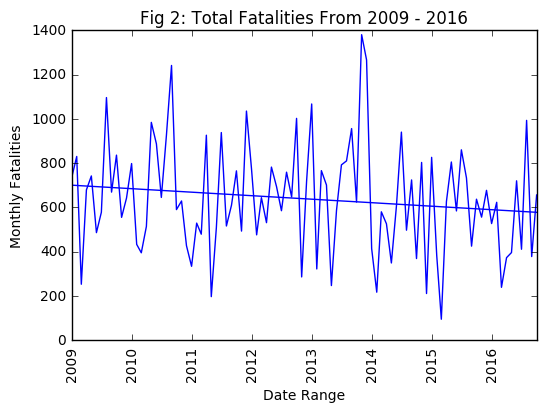

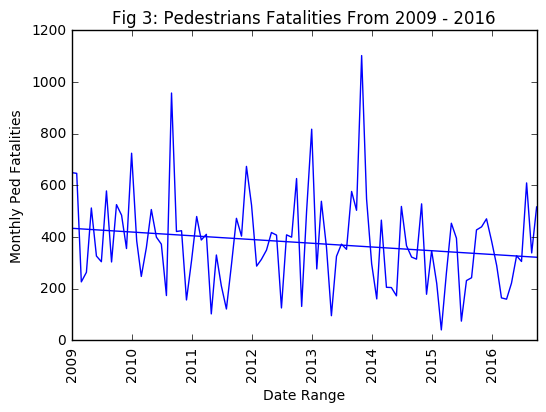

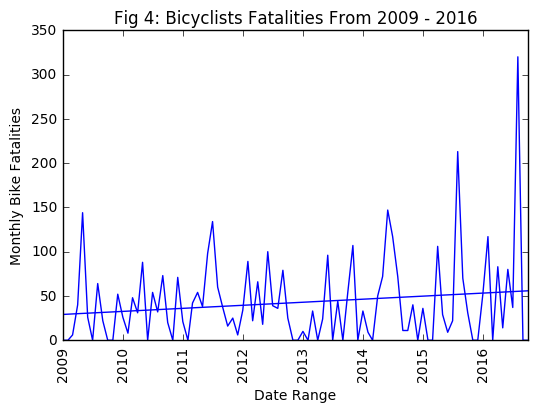

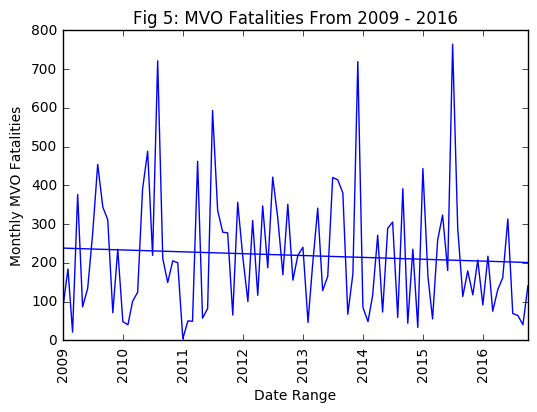

In [21]:
#Vizualizing trends 

#Total monthly fatalities including 3 major groups
plt.plot(fatalities_data_monthly_v2['Date'],fatalities_data_monthly_v2['Fatalities'],'blue')
plt.ylabel('Monthly Fatalities', size=10)
plt.xlabel('Date Range', size=10)
pl.plot(fatalities_data_monthly_v2['Date'], model.predict(sm.add_constant(x)))
plt.xticks(rotation=90)
plt.title('Fig 2: Total Fatalities From 2009 - 2016', size = 12)
plt.show()


#pedestrians fataities trend 
plt.plot(fatalities_data_monthly_v2['Date'],fatalities_data_monthly_v2['PedFatalit'],'blue')
plt.ylabel('Monthly Ped Fatalities', size=10)
plt.xlabel('Date Range', size=10)
pl.plot(fatalities_data_monthly_v2['Date'], model_ped.predict(sm.add_constant(x_ped)))
plt.xticks(rotation=90)
plt.title('Fig 3: Pedestrians Fatalities From 2009 - 2016', size = 12)
plt.show()

#bicyclists fatalities trend
plt.plot(fatalities_data_monthly_v2['Date'],fatalities_data_monthly_v2['BikeFatali'],'blue')
plt.ylabel('Monthly Bike Fatalities', size=10)
plt.xlabel('Date Range', size=10)
pl.plot(fatalities_data_monthly_v2['Date'], model_bike.predict(sm.add_constant(x_bike)))
plt.xticks(rotation=90)
plt.title('Fig 4: Bicyclists Fatalities From 2009 - 2016', size = 12)
plt.show()

#MVO fatalities trend
plt.plot(fatalities_data_monthly_v2['Date'],fatalities_data_monthly_v2['MVOFatalit'],'blue')
plt.ylabel('Monthly MVO Fatalities', size=10)
plt.xlabel('Date Range', size=10)
pl.plot(fatalities_data_monthly_v2['Date'], model_mvo.predict(sm.add_constant(x_mvo)))
plt.xticks(rotation=90)
plt.title('Fig 5: MVO Fatalities From 2009 - 2016', size = 12)
plt.show()


#### Figures 2 to 5 shows trend over 8 years of fatalities from road accidents. While trend for pedestrians fatalities and MVO fatalities is declining, the trend for bicyclists is increasing. One of the resons for increasing in bicyclists fatalities could be the fact of increased number of bicycles from city bike project, but this question needs to be explored additionally. 

### Localization of some high-risk locations in 5 boroughs for 3 major groups

In [22]:
#Loading json file of monthly fatalities for geospatial analysis
#os.system("curl -O http://www.nyc.gov/html/dot/downloads/misc/fatality_all_monthly.json")
#os.system("mv fatality_all_monthly.json " + os.getenv("PUIDATA"))

In [23]:
fatalities_monthly_ = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + '/' + 'fatality_all_monthly.json')

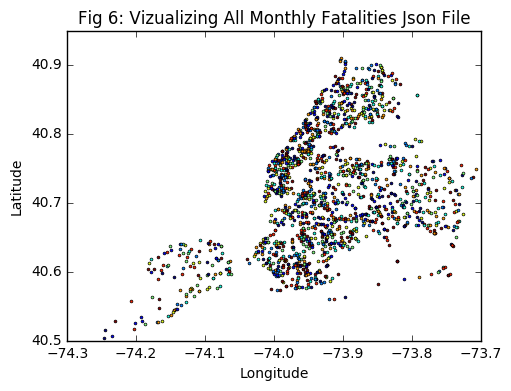

In [24]:
fatalities_monthly_.plot()
pl.title('Fig 6: Vizualizing All Monthly Fatalities Json File')
plt.ylabel('Latitude', size=10)
plt.xlabel('Longitude', size=10)

In [25]:
#Preparing pedestrians fatalities dataset for heatmap
fatalities_monthly_['Date'] = fatalities_monthly_.\
apply(lambda x: pd.datetime.strptime("{0} {1}".format(x['YR'],x['MN']), "%Y %m"),axis=1)

In [26]:
fatalities_monthly_ped = fatalities_monthly_[['PedFatalit', 'Date', 'geometry']]
fatalities_monthly_ped.head()

,PedFatalit,Date,geometry
0,1,2009-10-01,POINT (-73.89052628583379 40.81151194094214)
1,1,2009-10-01,POINT (-73.9002758732755 40.86378763472604)
2,1,2009-10-01,POINT (-73.96759867796442 40.58037846976183)
3,0,2009-10-01,POINT (-73.93371553950162 40.8442463745161)
4,0,2009-10-01,POINT (-74.0824393060315 40.57610793848944)


In [27]:
fatalities_monthly_ped = fatalities_monthly_ped.replace(0,nan)
fatalities_monthly_ped = fatalities_monthly_ped.dropna(how='any',axis=0)

In [28]:
fatalities_monthly_ped.head()

,PedFatalit,Date,geometry
0,1.0,2009-10-01,POINT (-73.89052628583379 40.81151194094214)
1,1.0,2009-10-01,POINT (-73.9002758732755 40.86378763472604)
2,1.0,2009-10-01,POINT (-73.96759867796442 40.58037846976183)
6,1.0,2009-10-01,POINT (-73.86272633841989 40.74986793616723)
8,1.0,2009-10-01,POINT (-73.98134068728926 40.74707866223923)


In [29]:
len(fatalities_monthly_ped) #number of fatalities in dataset for pedestrians

1055

In [30]:
#Creating a heatmap to define high risk fataities
def heatmap(d, bins=(100,100), smoothing=0.01, cmap='OrRd'):
    def getx(fatalities_monthly_ped):
        return fatalities_monthly_ped.coords[0][0]

    def gety(fatalities_monthly_ped):
        return fatalities_monthly_ped.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    plt.figure(figsize=(8,8))
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    #plt.ylabel('Latitude', size=10)
    #plt.xlabel('Longitude', size=10)
    plt.title('Fig 7: Pedestrians Fatalities Heatmap for 2009 - 2016')
    plt.show()
    
    return heatmap, xedges, yedges #returns number of fatalities and coordinates

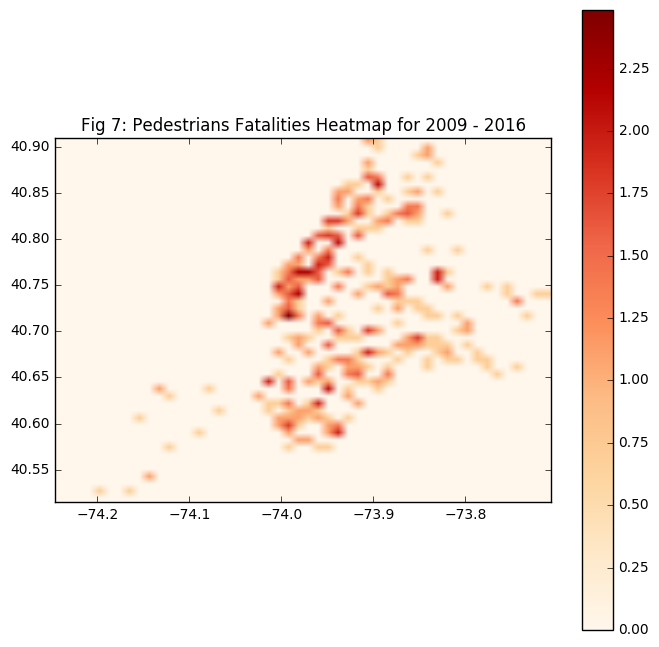

(array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([ 40.5147111 ,  40.52261946,  40.53052781,  40.53843617,
         40.54634452,  40.55425288,  40.56216124,  40.57006959,
         40.57797795,  40.5858863 ,  40.59379466,  40.60170301,
         40.60961137,  40.61751973,  40.62542808,  40.63333644,
         40.64124479,  40.64915315,  40.65706151,  40.66496986,
         40.67287822,  40.68078657,  40.68869493,  40.69660329,
         40.70451164,  40.71242   ,  40.72032835,  40.72823671,
         40.73614507,  40.74405342,  40.75196178,  40.75987013,
         40.76777849,  40.77568685,  40.7835952 ,  40.79150356,
         40.79941191,  40.80732027,  40.81522862,  40.82313698,
         40.83104534,  40.83895369,  40.84686205,  40.8547704 ,
         4

In [31]:
heatmap(fatalities_monthly_ped, bins=50, smoothing=0.1)

#### Figure 7 heatmap visualizing pedestrian fatalities in NYC occured between 2009 and 2016. Original data presented in epsg=4326: lat/on

In [32]:
#converting epsg=4326: lat/on to epsg=2263 is US feet
fatalities_monthly_ped.crs = from_epsg(4326)
fat_lo = fatalities_monthly_ped.to_crs(epsg=2263)

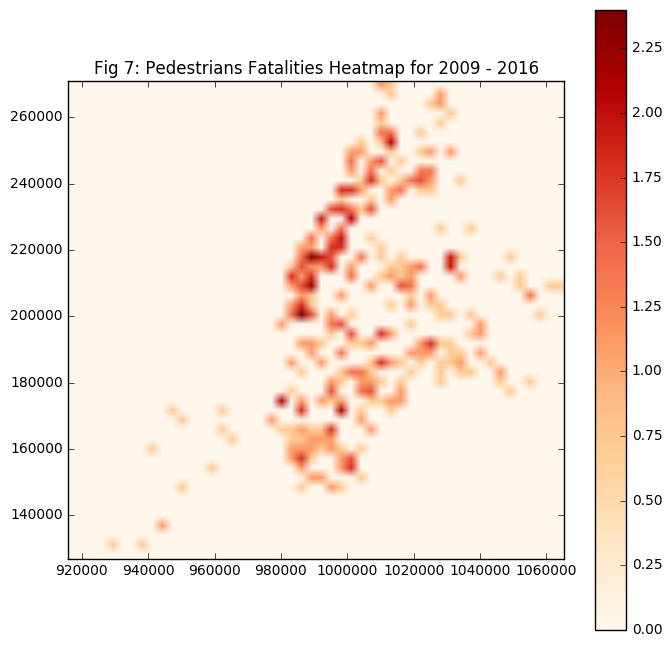

In [33]:
binned2Dpedestrians = heatmap(fat_lo, bins=50, smoothing=0.1)

#### Figure 7 heatmap visualizing pedestrian fatalities in NYC occured between 2009 and 2016. Data converted to epsg=2263 is US feet

In [34]:
#binned2Dpedestrians
#defining the highest fatality of pedestrians 
maxped = np.where(binned2Dpedestrians[0] == binned2Dpedestrians[0].max())
binned2Dpedestrians[1][maxped[0]], binned2Dpedestrians[2][maxped[1]]
xsize = binned2Dpedestrians[1][1]-binned2Dpedestrians[1][0]
ysize = binned2Dpedestrians[2][1]-binned2Dpedestrians[2][0]
ymaxped, xmaxped = binned2Dpedestrians[1][maxped[0]] + xsize * 0.5,\
                binned2Dpedestrians[2][maxped[1]] + ysize * 0.5


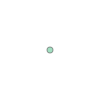

In [35]:
#define geometry point with max pedestrians fatalities
shape_maxped = shapely.geometry.Point((xmaxped, ymaxped))
shape_maxped

In [36]:
#get NYC zip code boundaries data
#os.system("curl -O https://data.cityofnewyork.us/download/i8iw-xf4u/ZIP_CODE_040114.zip")
#os.system("mv ZIP_CODE_040114.zip " + os.getenv("PUIDATA"))
#os.system('unzip ' + os.getenv("PUIDATA") + '/' + 'ZIP_CODE_040114.zip')
#zip_path = gp.GeoDataFrame.from_file('ZIP_CODE_040114.shp')

In [37]:
#NYC zip code boundaries 
zip_path = "ZIP_CODE_040114.shp"
zip_geod = GeoDataFrame.from_file(zip_path) 

In [38]:
#define zip code with max pedestrians fatalities
isave = 0
for i,g in enumerate(zip_geod['geometry']):
    if g.contains(shape_maxped):
        print zip_geod.iloc[i] 


AREA                                                2.62801e+07
BLDGZIP                                                       0
COUNTY                                                 New York
CTY_FIPS                                                    061
POPULATION                                                81305
PO_NAME                                                New York
SHAPE_AREA                                                    0
SHAPE_LEN                                                     0
STATE                                                        NY
ST_FIPS                                                      36
URL                                        http://www.usps.com/
ZIPCODE                                                   10002
geometry      POLYGON ((991339.8703228086 207576.7837151289,...
Name: 92, dtype: object


#### The most dangerous location for pedestrians is placed in zip 10002, lower east side downtown Manhattan

In [39]:
#preparing dataframe for bicyclists fatalities
fatalities_monthly_bicyclists = fatalities_monthly_[['BikeFatali', 'Date', 'geometry' ]]
fatalities_monthly_bicyclists.head()

,BikeFatali,Date,geometry
0,0,2009-10-01,POINT (-73.89052628583379 40.81151194094214)
1,0,2009-10-01,POINT (-73.9002758732755 40.86378763472604)
2,0,2009-10-01,POINT (-73.96759867796442 40.58037846976183)
3,0,2009-10-01,POINT (-73.93371553950162 40.8442463745161)
4,0,2009-10-01,POINT (-74.0824393060315 40.57610793848944)


In [40]:
fatalities_monthly_bicyclists = fatalities_monthly_bicyclists.replace(0,nan)
fatalities_monthly_bicyclists = fatalities_monthly_bicyclists.dropna(how='any',axis=0)

In [41]:
len(fatalities_monthly_bicyclists) #number of fatalities in dataset for bicyclists

129

In [42]:
#converting epsg=4326: lat/on to epsg=2263 is US feet
fatalities_monthly_bicyclists.crs = from_epsg(4326)
fat_bicyclists = fatalities_monthly_bicyclists.to_crs(epsg=2263)

In [43]:
#Creating a heatmap to define high risk fataities
def heatmap2(t, bins=(100,100), smoothing=0.01, cmap='OrRd'):
    def getx(fatalities_monthly_bicyclists):
        return fatalities_monthly_bicyclists.coords[0][0]

    def gety(fatalities_monthly_bicyclists):
        return fatalities_monthly_bicyclists.coords[0][1]

    x = list(t.geometry.apply(getx))
    y = list(t.geometry.apply(gety))
    heatmap2, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap2 = np.log(heatmap2)
    logheatmap2[np.isneginf(logheatmap2)] = 0
    logheatmap2 = ndimage.filters.gaussian_filter(logheatmap2, smoothing, mode='nearest')
    plt.figure(figsize=(8,8))
    plt.imshow(logheatmap2, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    #plt.ylabel('Latitude', size=10)
    #plt.xlabel('Longitude', size=10)
    plt.title('Fig 8: Bicyclists Fatalities Heatmap for 2009 - 2016')
    plt.show()
    
    return heatmap2, xedges, yedges #returns number of fatalities and coordinates

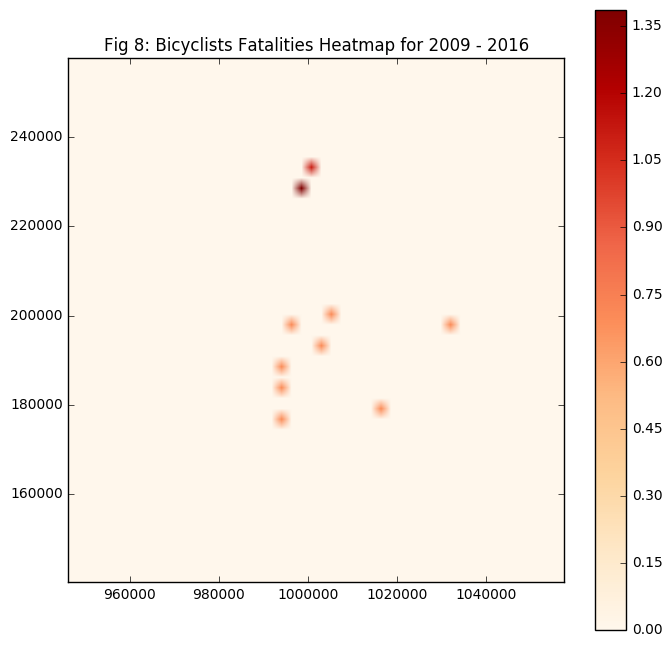

In [44]:
binned2Dbicyclists = heatmap2(fat_bicyclists, bins=50, smoothing=0.1)

#### Figure 8 heatmap visualizing bicyclists fatalities in NYC occured between 2009 and 2016. Data converted to epsg=2263 is US feet

In [45]:
#binned2Dbicyclists
#defining the highest fatality of bicyclysts 
maxbike = np.where(binned2Dbicyclists[0] == binned2Dbicyclists[0].max())
binned2Dbicyclists[1][maxbike[0]], binned2Dbicyclists[2][maxbike[1]]
xsize = binned2Dbicyclists[1][1]-binned2Dbicyclists[1][0]
ysize = binned2Dbicyclists[2][1]-binned2Dbicyclists[2][0]
ymaxbike, xmaxbike = binned2Dbicyclists[1][maxbike[0]] + xsize * 0.5,\
                binned2Dbicyclists[2][maxbike[1]] + ysize * 0.5

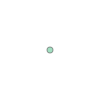

In [46]:
#define geometry point with max bicyclists fatalities
shape_maxbike = shapely.geometry.Point((xmaxbike, ymaxbike))
shape_maxbike

In [47]:
#define zip code with max bicyclists fatalities
isave = 0
for i,g in enumerate(zip_geod['geometry']):
    if g.contains(shape_maxbike):
        print zip_geod.iloc[i] 

AREA                                                2.29634e+07
BLDGZIP                                                       0
COUNTY                                                 New York
CTY_FIPS                                                    061
POPULATION                                                77503
PO_NAME                                                New York
SHAPE_AREA                                                    0
SHAPE_LEN                                                     0
STATE                                                        NY
ST_FIPS                                                      36
URL                                        http://www.usps.com/
ZIPCODE                                                   10029
geometry      POLYGON ((999072.8305786401 230985.3760054708,...
Name: 53, dtype: object


#### The most dangerous location for bicyclists is placed in zip 10029, east Harlem uptown Manhattan

In [48]:
#preparing data frame for mvo fatalities
fatalities_monthly_mvo = fatalities_monthly_[['MVOFatalit', 'Date', 'geometry' ]]
fatalities_monthly_mvo.head()

,MVOFatalit,Date,geometry
0,0,2009-10-01,POINT (-73.89052628583379 40.81151194094214)
1,0,2009-10-01,POINT (-73.9002758732755 40.86378763472604)
2,0,2009-10-01,POINT (-73.96759867796442 40.58037846976183)
3,1,2009-10-01,POINT (-73.93371553950162 40.8442463745161)
4,1,2009-10-01,POINT (-74.0824393060315 40.57610793848944)


In [49]:
#converting 0 to nan and dropping nan values
fatalities_monthly_mvo = fatalities_monthly_mvo.replace(0,nan)
fatalities_monthly_mvo = fatalities_monthly_mvo.dropna(how='any',axis=0)

In [50]:
len(fatalities_monthly_mvo) #number of fatalities in dataset for mvo

485

In [51]:
#converting epsg=4326: lat/on to epsg=2263 is US feet
fatalities_monthly_mvo.crs = from_epsg(4326)
fat_mvo = fatalities_monthly_mvo.to_crs(epsg=2263)

In [52]:
#Creating a heatmap to define high risk fataities
def heatmap3(t, bins=(100,100), smoothing=0.01, cmap='OrRd'):
    def getx(fatalities_monthly_mvo):
        return fatalities_monthly_mvo.coords[0][0]

    def gety(fatalities_monthly_mvo):
        return fatalities_monthly_mvo.coords[0][1]

    x = list(t.geometry.apply(getx))
    y = list(t.geometry.apply(gety))
    heatmap3, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap3 = np.log(heatmap3)
    logheatmap3[np.isneginf(logheatmap3)] = 0
    logheatmap3 = ndimage.filters.gaussian_filter(logheatmap3, smoothing, mode='nearest')
    plt.figure(figsize=(8,8))
    plt.imshow(logheatmap3, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    #plt.ylabel('Latitude', size=10)
    #plt.xlabel('Longitude', size=10)
    plt.title('Fig 9: MVO Fatalities Heatmap for 2009 - 2016')
    plt.show()
    
    return heatmap3, xedges, yedges #returns number of fatalities and coordinates

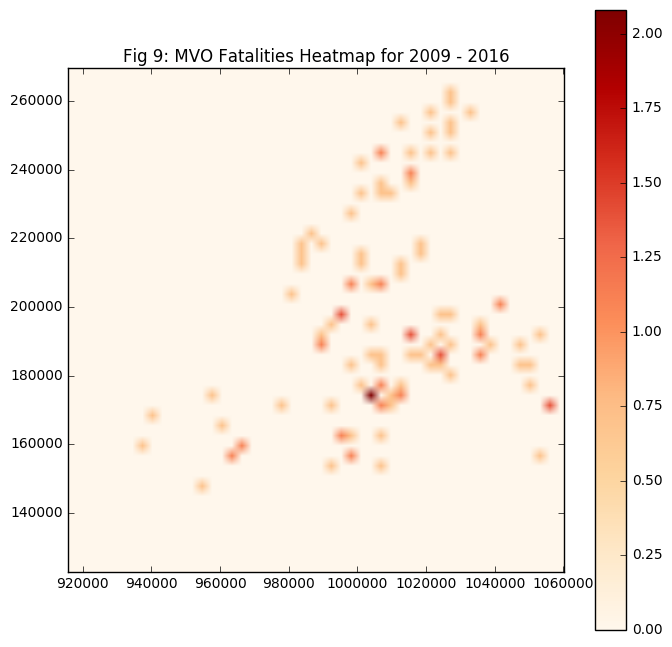

In [53]:
binned2Dmvo = heatmap3(fat_mvo, bins=50, smoothing=0.1)

#### Figure 9 heatmap visualizing mvo fatalities in NYC occured between 2009 and 2016. Data converted to epsg=2263 is US feet

In [54]:
#binned2Dmvo
#defining the highest fatality of mvo 
maxmvo = np.where(binned2Dmvo[0] == binned2Dmvo[0].max())
binned2Dmvo[1][maxmvo[0]], binned2Dmvo[2][maxmvo[1]]
xsize = binned2Dmvo[1][1]-binned2Dmvo[1][0]
ysize = binned2Dmvo[2][1]-binned2Dmvo[2][0]
ymaxmvo, xmaxmvo = binned2Dmvo[1][maxmvo[0]] + xsize * 0.5,\
                binned2Dmvo[2][maxmvo[1]] + ysize * 0.5

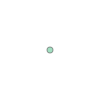

In [55]:
#define geometry point with max mvo fatalities
shape_maxmvo = shapely.geometry.Point((xmaxmvo, ymaxmvo))
shape_maxmvo

In [56]:
#define zip code with max mvo fatalities
isave = 0
for i,g in enumerate(zip_geod['geometry']):
    if g.contains(shape_maxmvo):
        print zip_geod.iloc[i]

AREA                                                6.06448e+07
BLDGZIP                                                       0
COUNTY                                                    Kings
CTY_FIPS                                                    047
POPULATION                                                78060
PO_NAME                                                Brooklyn
SHAPE_AREA                                                    0
SHAPE_LEN                                                     0
STATE                                                        NY
ST_FIPS                                                      36
URL                                        http://www.usps.com/
ZIPCODE                                                   11203
geometry      POLYGON ((1000147.787418231 181214.6701008826,...
Name: 126, dtype: object


#### The most dangerous location for mvo is placed in zip 11203, East Flatbush, Brooklyn